In [1]:
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import utils
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import preprocessing

In [2]:
df = pd.read_excel(r'./dataset.xlsx')
df = df.set_index(df.iloc[:,0].name)

In [3]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')
tracks = utils.load('./fma_metadata/tracks.csv')
genres = utils.load('./fma_metadata/genres.csv')
features = utils.load('./fma_metadata/features.csv')
echonest = utils.load('./fma_metadata/echonest.csv')
np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

In [4]:
df['year']  = tracks['track','date_created'].dt.year

In [5]:
df['year'].value_counts()

2009    3756
2010    3447
2011    1758
2008    1615
2012     569
2013     497
2014     441
2015     386
Name: year, dtype: int64

pre2011 = 8818; post = 3651; tot = 12469

## Decision Tree pre2011

In [6]:
pre2011 = [1 if x<2011 else 0 for x in df['year']]
df['pre2011']= pre2011 
df=df.drop('year', axis=1)

In [7]:
def report(results, n_top=3):
    md = []
    ms = []
    ml = []
    cr = []
    mean = []
    std = []
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            mean.append( results['mean_test_score'][candidate])
            std.append(results['std_test_score'][candidate])
            ms.append(random_search.cv_results_['params'][candidate]['min_samples_split'])
            ml.append(random_search.cv_results_['params'][candidate]['min_samples_leaf'])
            cr.append(random_search.cv_results_['params'][candidate]['criterion'])
            md.append(random_search.cv_results_['params'][candidate]['max_depth'])
    dres = pd.DataFrame()
    dres['Mean Test Score'] = mean
    dres['Standard Deviation Test Score'] = std
    dres['Min Sample Leaf'] = ml
    dres['Min Sample Split'] = ms
    dres['Criterion'] = cr
    dres['Max Depth'] = md
    return dres

def report_verbose(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [8]:
attributes = [col for col in df.columns if col != 'pre2011']
X = df[attributes].values
y = df['pre2011']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

In [9]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(7481, 20)
(4988, 20)
(7481,)
(4988,)


In [10]:
param_list = {'max_depth': [None] + list(np.arange(2, 50)),
              'min_samples_split': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,160,170,180,190,200],
              'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,160,170,180,190,200],
              'criterion': ['gini', 'entropy'],
             }

dtc = DecisionTreeClassifier()
skf = RepeatedStratifiedKFold(n_splits=10, random_state=123)

cvs = []
results = []

random_search = RandomizedSearchCV(dtc, param_distributions=param_list, n_iter=50, cv = 10)

random_search.fit(X, y)
dres = pd.DataFrame
dres = report(random_search.cv_results_, n_top=20).copy()
report_verbose(random_search.cv_results_, n_top=2)

Model with rank: 1
Mean validation score: 0.758 (std: 0.071)
Model with rank: 1
Parameters: {'min_samples_split': 80, 'min_samples_leaf': 50, 'max_depth': 9, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.758 (std: 0.066)
Model with rank: 2
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 200, 'max_depth': 12, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.758 (std: 0.066)
Model with rank: 2
Parameters: {'min_samples_split': 70, 'min_samples_leaf': 200, 'max_depth': 6, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.758 (std: 0.066)
Model with rank: 2
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 200, 'max_depth': 38, 'criterion': 'gini'}



In [34]:
#parametri migliori
dres.sort_values(by='Mean Test Score' , ascending = False).head(3)

,Mean Test Score,Standard Deviation Test Score,Min Sample Leaf,Min Sample Split,Criterion,Max Depth
0,0.758283,0.070532,50,80,gini,9
2,0.757961,0.065759,200,70,gini,6
3,0.757961,0.065759,200,10,gini,38


In [11]:
print(random_search.best_estimator_)
dtc = random_search.best_estimator_
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_pred_tr = dtc.predict(X_train)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=50, min_samples_split=80)


In [12]:
for col, imp in zip(attributes, dtc.feature_importances_):
    print(col, imp)

acousticness 0.3151898761304612
danceability 0.04284252114117765
energy 0.027029626419010144
instrumentalness 0.26770046416107446
liveness 0.001536569391019876
speechiness 0.04046372557415348
tempo 0.007857178643206054
valence 0.008364743034157738
mfcc_mean 0.003297499503217278
chroma_cens_mean 0.011172478054521337
chroma_cqt_mean 0.006743183388324919
chroma_stft_mean 0.027158217984167246
tonnetz_mean 0.018263523514835876
spectral_contrast_mean 0.06136603571023901
spectral_centroid_mean 0.032838629045408976
spectral_bandwidth_mean 0.053339935238764305
spectral_rolloff_mean 0.02906421907393634
rmse_mean 0.008366800666982326
zcr_mean 0.030854355382698862
Electronic labeler 0.006550417942643023


Text(0.5, 0, 'Importance')

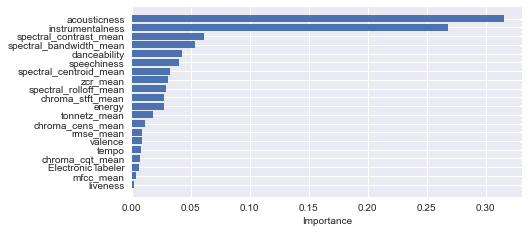

In [13]:
plt.figure(figsize=(7, 3.5))
plt.style.use('seaborn')
feature = pd.DataFrame({'Feature_name': attributes, 'Importances' : dtc.feature_importances_})
feature = feature.sort_values('Importances' , ascending = True)
feature = feature[feature['Importances'] > 0.0]
plt.barh (feature['Feature_name'] , feature['Importances'])
plt.xlabel("Importance", size=10)
#plt.ylabel("Feature", size=18)
#plt.title("Decision Tree feature importances", size=21)

[Text(4068.75, 2312.1875, 'instrumentalness <= 0.124\ngini = 0.414\nsamples = 7481\nvalue = [2190, 5291]\nclass = pre 2011'),
 Text(2034.375, 1651.5625, 'acousticness <= 0.319\ngini = 0.499\nsamples = 1501\nvalue = [776, 725]\nclass = post 2011'),
 Text(1017.1875, 990.9375, 'speechiness <= 0.329\ngini = 0.352\nsamples = 623\nvalue = [481, 142]\nclass = post 2011'),
 Text(508.59375, 330.3125, '\n  (...)  \n'),
 Text(1525.78125, 330.3125, '\n  (...)  \n'),
 Text(3051.5625, 990.9375, 'spectral_centroid_mean <= 1277.085\ngini = 0.446\nsamples = 878\nvalue = [295, 583]\nclass = pre 2011'),
 Text(2542.96875, 330.3125, '\n  (...)  \n'),
 Text(3560.15625, 330.3125, '\n  (...)  \n'),
 Text(6103.125, 1651.5625, 'acousticness <= 0.009\ngini = 0.361\nsamples = 5980\nvalue = [1414, 4566]\nclass = pre 2011'),
 Text(5085.9375, 990.9375, 'danceability <= 0.536\ngini = 0.48\nsamples = 667\nvalue = [267, 400]\nclass = pre 2011'),
 Text(4577.34375, 330.3125, '\n  (...)  \n'),
 Text(5594.53125, 330.3125, 

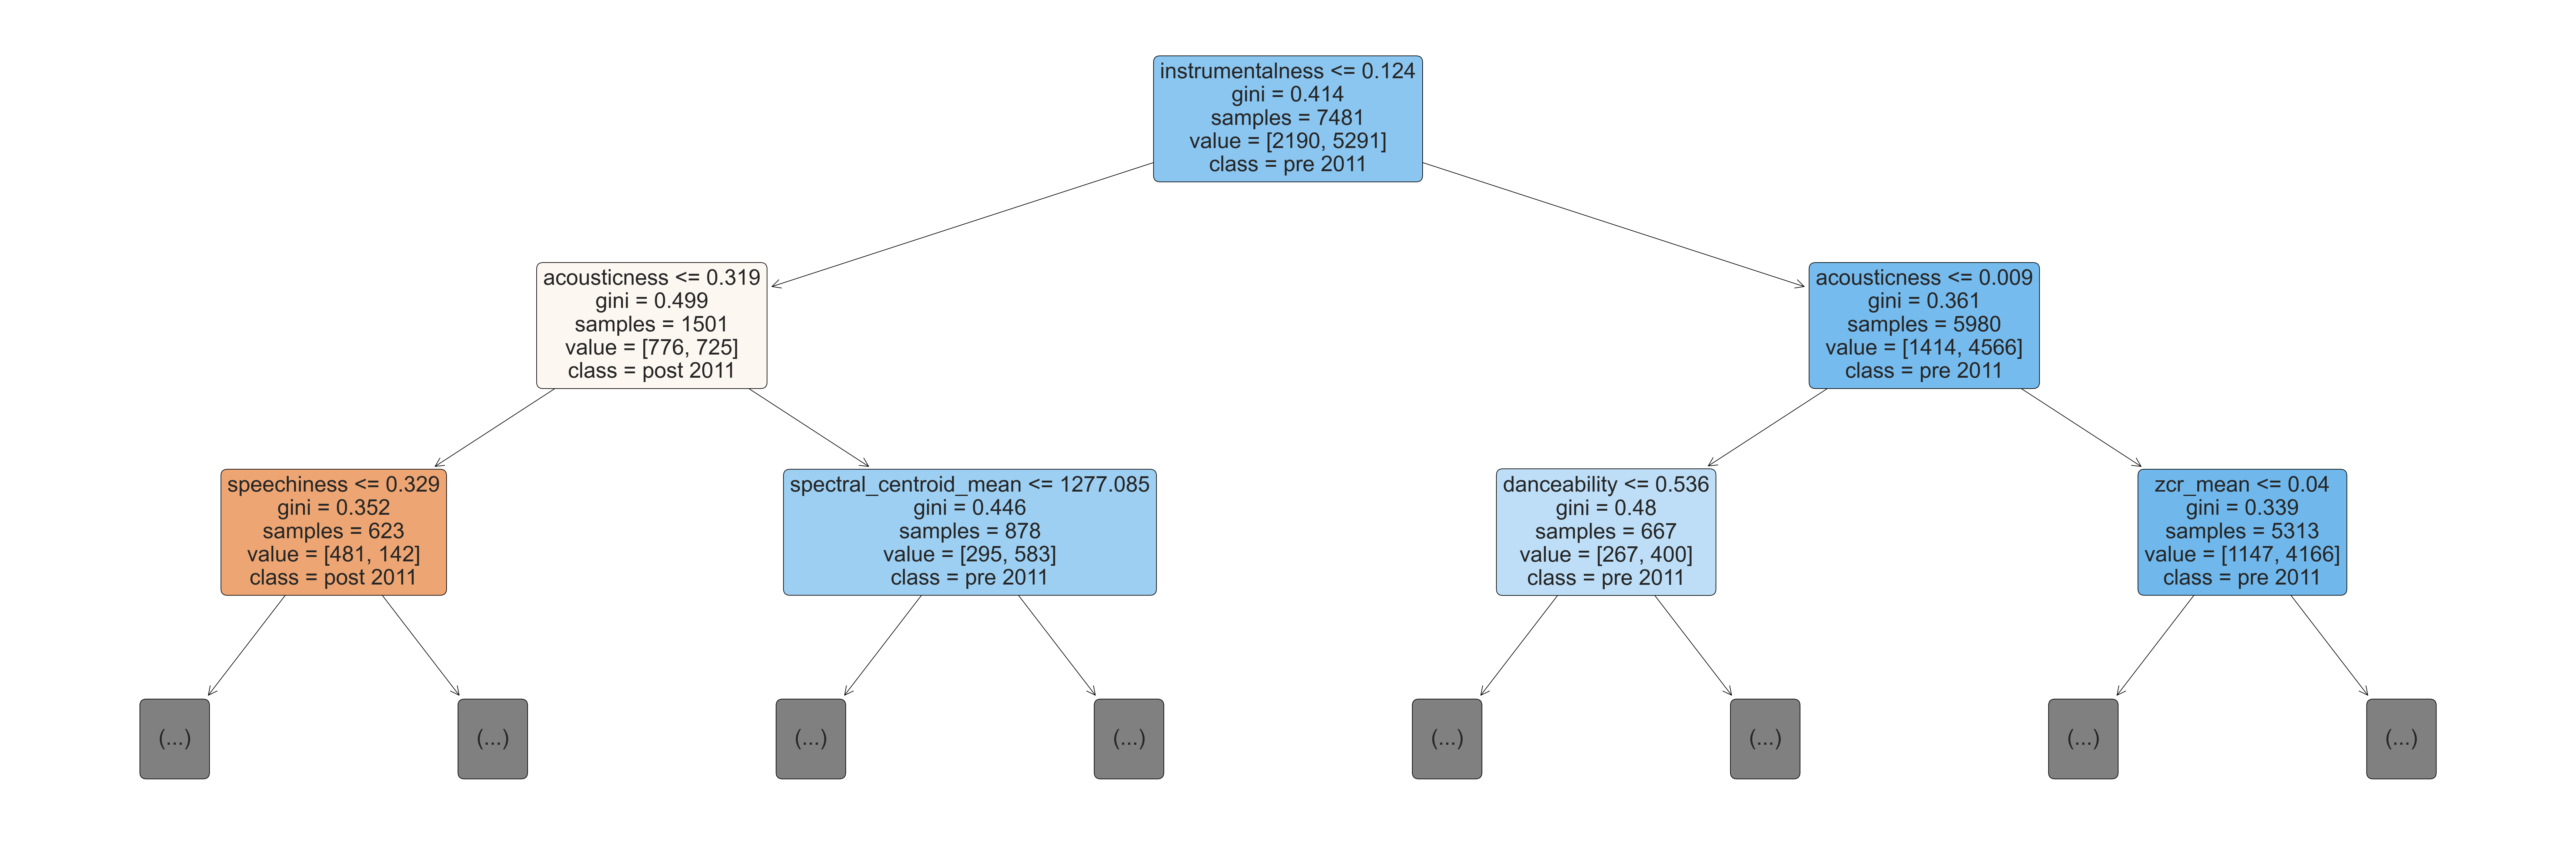

In [14]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (21,7), dpi=500)
sklearn.tree.plot_tree(dtc,feature_names=attributes,
                        class_names=['pre 2011' if x == 1 else 'post 2011' for x in dtc.classes_],  
                        filled=True, rounded=True,                       
                        label = 'all' , max_depth = 2, fontsize = 10)

In [15]:
y_pred_tr = dtc.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))

confusion_matrix(y_train, y_pred_tr)

Train Accuracy 0.7879962571848683
Train F1-score [0.52429514 0.86360509]
              precision    recall  f1-score   support

           0       0.76      0.40      0.52      2190
           1       0.79      0.95      0.86      5291

    accuracy                           0.79      7481
   macro avg       0.78      0.67      0.69      7481
weighted avg       0.78      0.79      0.76      7481



array([[ 874, 1316],
       [ 270, 5021]])

In [16]:
y_pred = dtc.predict(X_test)
print('Train Accuracy %s' % accuracy_score(y_test, y_pred))
print('Train F1-score %s' % f1_score(y_test, y_pred, average=None))
print()
print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

Train Accuracy 0.7610264635124299
Train F1-score [0.46014493 0.84654995]

              precision    recall  f1-score   support

           0       0.68      0.35      0.46      1461
           1       0.78      0.93      0.85      3527

    accuracy                           0.76      4988
   macro avg       0.73      0.64      0.65      4988
weighted avg       0.75      0.76      0.73      4988



array([[ 508,  953],
       [ 239, 3288]])

0.6365740808123972


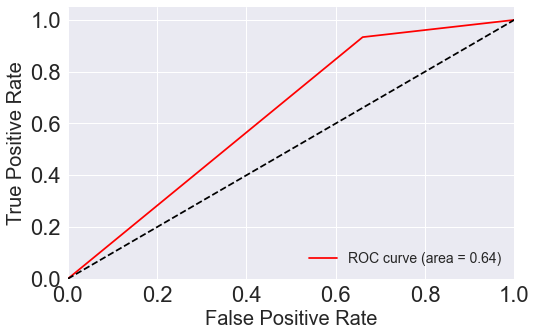

In [18]:
dtc = random_search.best_estimator_
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_pred_tr = dtc.predict(X_train)

fpr1, tpr1, _ = roc_curve(y_test, y_pred)
roc_auc1 = auc(fpr1, tpr1)
print(roc_auc1)

roc_auc1 = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 5))
plt.plot(fpr1, tpr1, label='ROC curve (area = %0.2f)' % (roc_auc1), c = 'r')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0],)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

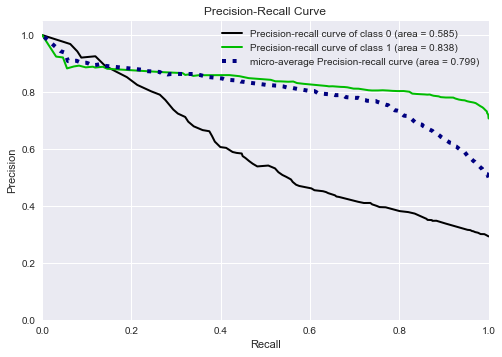

In [19]:
y_score = dtc.predict_proba(X_test)

plot_precision_recall(y_test, y_score)
plt.show()

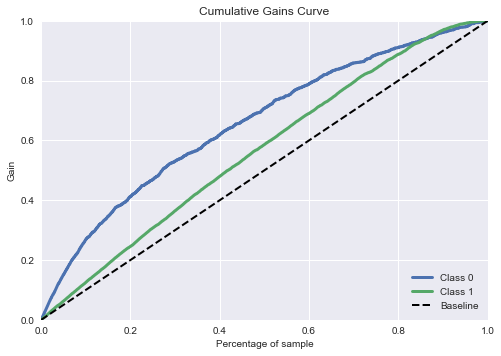

In [20]:
plot_cumulative_gain(y_test, y_score)
plt.show()

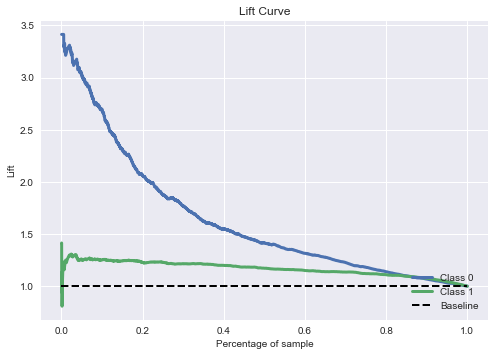

In [21]:
plot_lift_curve(y_test, y_score)
plt.show()

## KNN

In [22]:
df=df.drop('Electronic labeler', axis=1)

In [23]:
scaler = MinMaxScaler()
scaler = preprocessing.StandardScaler()

df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']] = scaler.fit_transform(df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']])

df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,mfcc_mean,chroma_cens_mean,chroma_cqt_mean,chroma_stft_mean,tonnetz_mean,spectral_contrast_mean,spectral_centroid_mean,spectral_bandwidth_mean,spectral_rolloff_mean,rmse_mean,zcr_mean,pre2011
track_id,,,,,,,,,,,,,,,,,,,,
2,-0.288519,0.982312,0.349387,-1.744299,-0.046462,0.482131,1.266050,0.490339,-0.438488,0.667869,0.652836,-0.552811,1.206044,-0.025942,1.036232,0.398672,0.847513,-0.552881,1.534804,1
3,-0.399234,0.207262,1.017482,-1.768594,-0.510031,2.777503,0.123731,-0.627530,0.199917,1.069189,1.086740,0.379882,0.235017,-0.024231,1.334086,0.730280,1.107144,-0.363652,1.486685,1
5,-1.265834,1.349028,0.593988,-1.771789,1.216329,0.218723,-0.658933,0.653973,0.004753,0.985098,0.858930,-0.351168,-0.577659,-0.023659,0.199770,0.156518,0.327997,-0.524571,0.046049,1
10,1.112839,0.889068,1.408383,0.898637,-0.448060,-0.476397,-0.327597,1.897323,0.010304,1.279819,1.670373,0.109657,-1.372757,-0.220586,0.361622,-0.080773,0.148707,-0.234162,1.163252,1
134,-0.195421,0.126178,0.078964,-1.719900,-0.570189,3.260855,-0.247622,1.644537,-0.071229,0.562875,0.855864,0.150201,-0.574985,-0.410579,0.114678,-0.350417,0.000517,-0.497763,0.561394,1


In [24]:
attributes = [col for col in df.columns if col != 'pre2011']
X = df[attributes].values
y = df['pre2011']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [25]:
param_list = {
    'n_neighbors' : list(range(1, 30)),
    'algorithm': ['ball_tree', 'kd_tree','brute'],
    'weights': ['distance','uniform'],
    'leaf_size' : list(range(1, 150)),
    'metric' : ['euclidean' , 'cosine', 'minkowski']
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(knn,param_distributions=param_list, n_iter=50, cv = 5)
random_search.fit(X, y)
report_verbose(random_search.cv_results_, n_top=3)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable functio

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable functio

Model with rank: 1
Mean validation score: 0.758 (std: 0.062)
Model with rank: 1
Parameters: {'weights': 'uniform', 'n_neighbors': 23, 'metric': 'cosine', 'leaf_size': 100, 'algorithm': 'brute'}

Model with rank: 2
Mean validation score: 0.758 (std: 0.059)
Model with rank: 2
Parameters: {'weights': 'distance', 'n_neighbors': 27, 'metric': 'euclidean', 'leaf_size': 108, 'algorithm': 'kd_tree'}

Model with rank: 2
Mean validation score: 0.758 (std: 0.059)
Model with rank: 2
Parameters: {'weights': 'distance', 'n_neighbors': 27, 'metric': 'euclidean', 'leaf_size': 26, 'algorithm': 'ball_tree'}

Model with rank: 2
Mean validation score: 0.758 (std: 0.059)
Model with rank: 2
Parameters: {'weights': 'distance', 'n_neighbors': 27, 'metric': 'euclidean', 'leaf_size': 95, 'algorithm': 'kd_tree'}



In [26]:
clf = random_search.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [27]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.7909983241560928
Train F1-score [0.51419032 0.86685984]
Test Accuracy 0.7778857837181045
Test F1-score [0.48709315 0.85825062]
              precision    recall  f1-score   support

           0       0.75      0.36      0.49      1205
           1       0.78      0.95      0.86      2910

    accuracy                           0.78      4115
   macro avg       0.77      0.66      0.67      4115
weighted avg       0.77      0.78      0.75      4115



array([[ 434,  771],
       [ 143, 2767]])

In [28]:
fpr3, tpr3, _ = roc_curve(y_test, y_pred)
roc_auc3 = auc(fpr3, tpr3)
print(roc_auc3)

roc_auc3 = roc_auc_score(y_test, y_pred, average=None)
roc_auc3

0.655512540816472


0.655512540816472

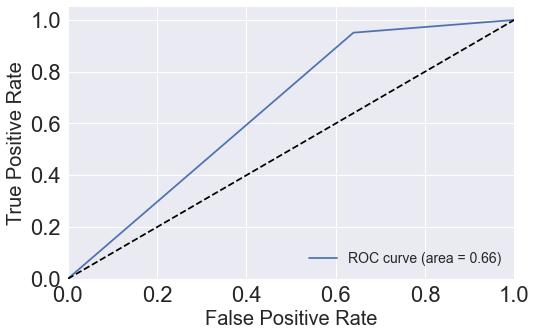

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(fpr3, tpr3, label='ROC curve (area = %0.2f)' % (roc_auc3))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

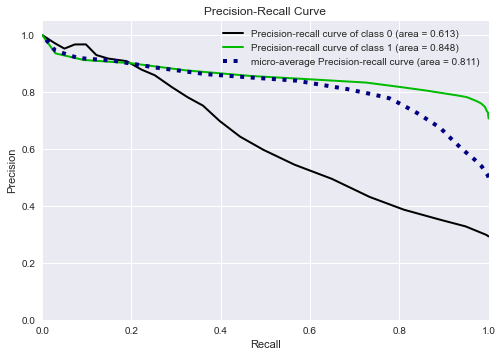

In [30]:
y_score = clf.predict_proba(X_test)

plot_precision_recall(y_test, y_score)
plt.show()

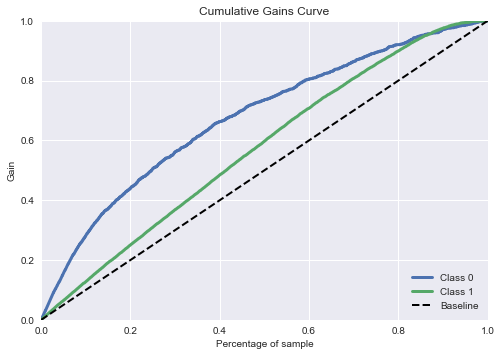

In [31]:
plot_cumulative_gain(y_test, y_score)
plt.show()

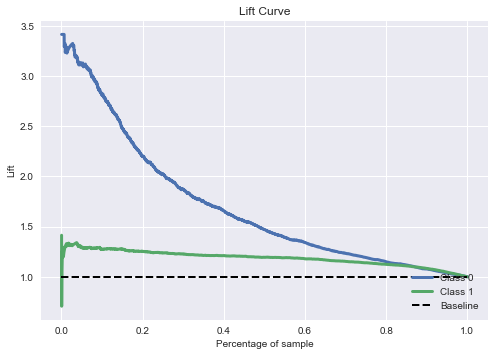

In [32]:
plot_lift_curve(y_test, y_score)
plt.show()

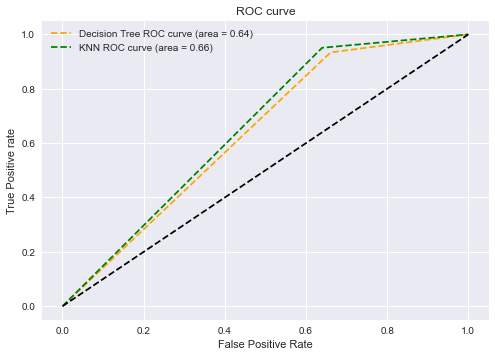

In [33]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Decision Tree ROC curve (area = %0.2f)' % (roc_auc1))
plt.plot(fpr3, tpr3, linestyle='--',color='green', label='KNN ROC curve (area = %0.2f)' % (roc_auc3))

plt.plot([0, 1], [0, 1], 'k--')

#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title

plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()